##### Это финальное задание по курсу «Поиск структуры в данных».

В нем вы попробуете визуализировать данные при помощи PCA и t-SNE и сравните визуально качество этих методов. Также вы попробуете использовать новые признаковые описания для повышения качества классификации объектов.

В качестве данных для этого задания будем использовать данные соревнования Otto Group Product Classification Challenge: https://www.kaggle.com/c/otto-group-product-classification-challenge

Так как данных там может быть слишком много для обработки на домашнем компьютере с помощью t-SNE, то мы сделали их случайную подвыборку и приложили к заданию (файл data.csv).

In [194]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from  sklearn.metrics import accuracy_score, log_loss
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, scale
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression

In [2]:
%matplotlib inline

### Загрузка данных

Загрузите данные из __data.csv__. Положите первые 70% объектов для обучения моделей, а оставшиеся 30% для контроля. Учтите, что первый столбец — это __id__ объекта и его нужно убрать из признаков (потому что сейчас классы объектов отсортированы по __id__). Так как некоторые алгоритмы и метрики считают, что метки классов — это последовательные числа с нуля, то сразу приведите целевую переменную к такому виду. Отрисовку и понижение размерности данных делайте сразу и для обучающей, и для тестовой выборки.

In [3]:
input_ = pd.read_csv("data.csv")

In [4]:
input_.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,7655,0,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,Class_2
1,5254,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,Class_2
2,7993,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,Class_2
3,6139,0,0,1,0,1,0,0,0,0,...,2,9,0,8,3,0,0,0,0,Class_2
4,10279,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,Class_2


In [5]:
input_.shape

(10000, 95)

Создаём копию , чтобы не портить исходный датасет

In [208]:
data = input_.copy()

Кодируем целевой признак

In [7]:
le = LabelEncoder()
data.target = le.fit_transform(data.target)

Удаялем признак id

In [209]:
data.drop("id", axis=1, inplace=True)

In [210]:
data.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,0,0,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,Class_2
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,Class_2
2,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,Class_2
3,0,0,1,0,1,0,0,0,0,2,...,2,9,0,8,3,0,0,0,0,Class_2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,Class_2


Делим датасет на обучение и тест, выделяем целевой признак

In [211]:
X = data.drop('target', axis=1)
y = data.target

In [212]:
X_train, X_test, y_train, y_test = train_test_split(data.drop("target", axis=1), data.target, test_size=0.3, shuffle=False)

In [213]:
X

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
0,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
3,0,0,1,0,1,0,0,0,0,2,...,0,2,9,0,8,3,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,2,0,2,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,3,1,0,0,0,13,1,0,...,0,0,0,0,1,3,0,0,0,0
9998,0,1,2,2,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0


In [214]:
y

0       Class_2
1       Class_2
2       Class_2
3       Class_2
4       Class_2
         ...   
9995    Class_9
9996    Class_6
9997    Class_9
9998    Class_6
9999    Class_1
Name: target, Length: 10000, dtype: object

### Визуализация с помощью PCA

Понизьте размерность данных до 2-ух с помощью метода главных компонент. Нарисуйте полученную выборку, при этом цветом выделите объекты разных классов.

In [14]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [15]:
X_pca[:5,]

array([[-4.75535857,  1.01421248],
       [-4.50760477, -2.07545366],
       [-3.5197179 , -3.22209253],
       [-4.73578812, -1.45763117],
       [-3.65694007, -2.43658026]])

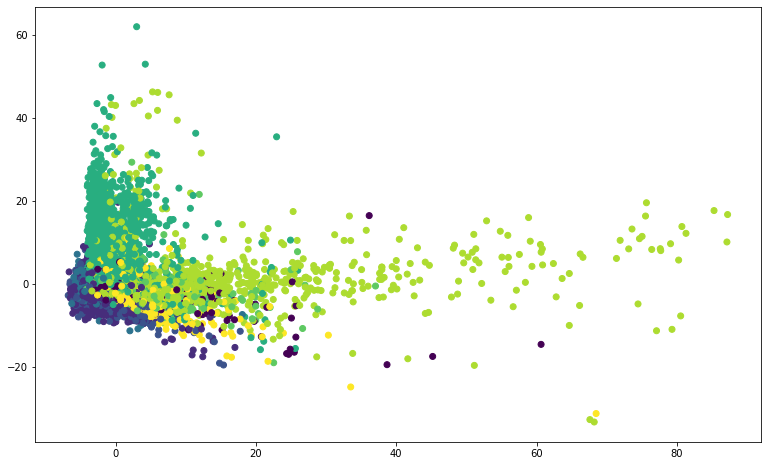

In [16]:
plt.figure(figsize=(13, 8))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
plt.show()

### Визуализация с помощью t-SNE

Теперь понизьте размерность данных до 2-ух с помощью метода t-SNE. В качестве параметров возьмите learning_rate=1000, init="random" и random_state=1234 (последнее — для воспроизводимости результата). Нарисуйте полученную выборку, при этом цветом выделите объекты разных классов. Сравните качественно разделимость классов при понижении размерности с помощью PCA и t-SNE.

In [17]:
%%time
tsne = TSNE(n_components = 2, init = 'random', random_state = 1234, learning_rate=1000)
X_tsne = tsne.fit_transform(X)

Wall time: 49.3 s


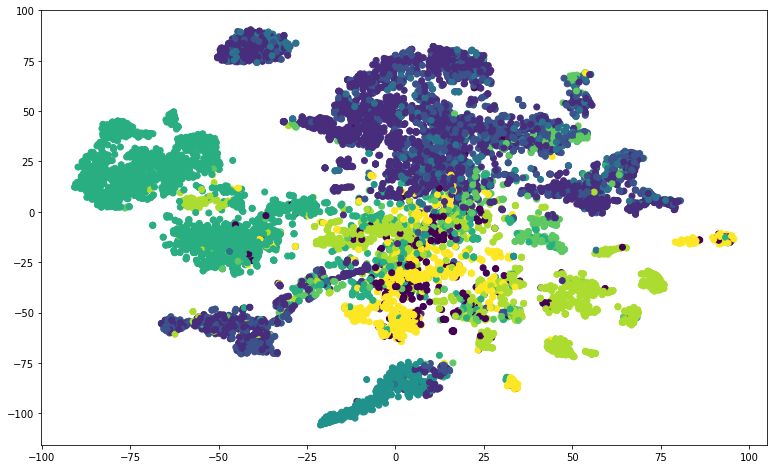

In [18]:
plt.figure(figsize=(13, 8))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y)
plt.show()

Разделимость классов при понижении размерности методом t-SNE лучше, чем методом PCA

### Обучение моделей

Обучите логистическую регрессию (linear_model.LogisticRegression) и случайный лес (ensemble.RandomForestClassifier) из sklearn. В первом случае подберите оптимальный параметр $C$ на отрезке $[10^{-4}, 10^{4}]$ (по степеням $10$ с шагом $1$, начиная с $-4$), а во втором при фиксированном числе деревьев в 50 подберите $max\_depth$ из отрезка $[2, 48]$ с шагом в 2. За целевую метрику качества возьмите мультиклассовый log-loss. В качестве схемы валидации используйте стратифицированную кросс-валидацию по 5-ти фолдам. Какие параметры оказались оптимальными? 

In [215]:
params_log_reg = {'C': [10**i for i in range(-4, 4)]}
params_rand_forest = {'max_depth': [i for i in range(2, 49, 2)]}

In [218]:
log_reg = GridSearchCV(estimator=LogisticRegression(max_iter=10000, multi_class='multinomial'), 
                       param_grid=params_log_reg, cv=5, scoring='neg_log_loss')

In [200]:
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)
X_train_scaled

array([[-0.24685595, -0.21311908,  0.03313978, ..., -0.13148525,
        -0.381165  , -0.10599006],
       [-0.24685595, -0.21311908, -0.30850743, ..., -0.13148525,
        -0.381165  , -0.10599006],
       [-0.24685595, -0.21311908, -0.30850743, ..., -0.13148525,
        -0.381165  , -0.10599006],
       ...,
       [-0.24685595, -0.21311908,  0.03313978, ..., -0.13148525,
        -0.381165  , -0.10599006],
       [-0.24685595, -0.21311908, -0.30850743, ...,  0.41669625,
         2.72134082, -0.10599006],
       [-0.24685595, -0.21311908, -0.30850743, ..., -0.13148525,
        -0.381165  , -0.10599006]])

In [219]:
%%time
log_reg.fit(X=X_train_scaled, y=y_train)

Wall time: 1min 57s


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=10000,
                                          multi_class='multinomial',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=0)

In [23]:
log_reg.best_params_

{'C': 0.1}

In [24]:
random_forest = GridSearchCV(estimator=RandomForestClassifier(n_estimators=50), 
                             param_grid=params_rand_forest, scoring='neg_log_loss', cv=5)

In [140]:
%%time
random_forest.fit(X=X_train_scaled, y=y_train)

Wall time: 55.3 s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=None,
                                              oob_score=False,
                                              random

In [132]:
random_forest.best_params_

{'max_depth': 26}

Посчитайте accuracy и log-loss на отложенной выборке для логистической регрессии и случайного леса. Какие они получились? Какой алгоритм лучше?

In [119]:
accuracy_score(y_true=y_test, y_pred=log_reg.predict(X_test_scaled))

0.741

In [141]:
accuracy_score(y_true=y_test, y_pred=random_forest.predict(X_test_scaled))

0.75

In [121]:
log_loss(y_true=y_test, y_pred=log_reg.predict_proba(X_test_scaled))

0.6994975845375596

In [142]:
log_loss(y_true=y_test, y_pred=random_forest.predict_proba(X_test_scaled))

0.7835317644177997

RandomForestClassifier немного лучше по accuracy, но хуже по log loss

### Использование PCA для улучшения классификации

Теперь попробуйте использовать PCA для улучшения качества классификации. Добавьте признаки из маломерного пространства (по 2 числа на каждый объект) в обучающую и тестовую выборку. Заново переподберите параметры к логистической регрессии и случайному лесу. Удалось ли таким образом улучшить качество моделей? Почему с теоретической точки зрения добавление признаков из PCA не должно улучшить качество логистической регрессии?

In [143]:
X_pca_train, X_pca_test = np.split(X_pca, indices_or_sections=[int(0.7*len(X_pca))])

Создаём копию обучения и теста для добавления признаков PCA

In [144]:
X_train_pca = X_train.copy()
X_test_pca = X_test.copy()

In [145]:
X_train_pca['pca1'] = pd.Series(X_pca_train[:, 0])
X_train_pca['pca2'] = pd.Series(X_pca_train[:, 1])

In [146]:
X_train_pca

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,pca1,pca2
0,0,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,-4.755359,1.014212
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,-4.507605,-2.075454
2,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,-3.519718,-3.222093
3,0,0,1,0,1,0,0,0,0,2,...,9,0,8,3,0,0,0,0,-4.735788,-1.457631
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,-3.656940,-2.436580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,7,0,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,-3.601292,-3.420399
6996,3,1,2,0,0,0,18,0,1,4,...,0,2,0,1,0,0,1,0,13.423794,2.041874
6997,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,-4.234396,-0.529742
6998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,1,3,0,-0.544248,3.598850


In [147]:
X_train_pca_scaled = scale(X_train_pca)

In [148]:
X_train_pca_scaled = pd.DataFrame(X_train_pca_scaled, columns=X_train.columns.append(pd.Index(['pca1', 'pca2'])))

In [150]:
X_train_pca_scaled

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,pca1,pca2
0,-0.246856,-0.213119,0.033140,0.091552,-0.163077,-0.119569,-0.185310,-0.295447,-0.285121,-0.247458,...,-0.400484,-0.249451,0.056704,-0.296424,-0.170362,-0.131485,-0.381165,-0.10599,-0.605986,0.150359
1,-0.246856,-0.213119,-0.308507,-0.289689,-0.163077,-0.119569,-0.185310,-0.295447,-0.285121,-0.247458,...,-0.051457,-0.249451,-0.421523,0.322784,-0.170362,-0.131485,-0.381165,-0.10599,-0.573956,-0.306970
2,-0.246856,-0.213119,-0.308507,-0.289689,-0.163077,-0.119569,-0.185310,-0.295447,-0.285121,-0.247458,...,-0.051457,0.390871,-0.421523,-0.296424,-0.170362,-0.131485,-0.381165,-0.10599,-0.446239,-0.476695
3,-0.246856,-0.213119,0.033140,-0.289689,1.943081,-0.119569,-0.185310,-0.295447,-0.285121,1.547575,...,2.740761,-0.249451,3.404296,1.561200,-0.170362,-0.131485,-0.381165,-0.10599,-0.603456,-0.215521
4,-0.246856,-0.213119,-0.308507,-0.289689,-0.163077,-0.119569,-0.185310,-0.295447,-0.285121,-0.247458,...,-0.400484,-0.249451,0.056704,-0.296424,-0.170362,-0.131485,-0.381165,-0.10599,-0.463979,-0.360424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,3.755772,-0.213119,-0.308507,-0.289689,-0.163077,-0.119569,-0.185310,-0.295447,-0.285121,-0.247458,...,0.995625,-0.249451,-0.421523,-0.296424,-0.170362,-0.131485,-0.381165,-0.10599,-0.456785,-0.506048
6996,1.468556,0.626405,0.374787,-0.289689,-0.163077,-0.119569,18.027713,-0.295447,0.005438,3.342607,...,-0.400484,1.031193,-0.421523,0.322784,-0.170362,-0.131485,0.653004,-0.10599,1.744268,0.302473
6997,-0.246856,-0.213119,0.033140,-0.289689,-0.163077,-0.119569,-0.185310,-0.295447,-0.285121,-0.247458,...,-0.051457,-0.249451,-0.421523,-0.296424,-0.170362,-0.131485,-0.381165,-0.10599,-0.538635,-0.078176
6998,-0.246856,-0.213119,-0.308507,-0.289689,-0.163077,-0.119569,-0.185310,-0.295447,-0.285121,-0.247458,...,-0.400484,-0.249451,-0.421523,0.941992,-0.170362,0.416696,2.721341,-0.10599,-0.061561,0.532935


In [151]:
X_test_pca

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
7000,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
7001,1,0,0,0,0,0,1,0,0,1,...,0,1,1,1,0,0,0,0,0,0
7002,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
7003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7004,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,2,0,2,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,3,1,0,0,0,13,1,0,...,0,0,0,0,1,3,0,0,0,0
9998,0,1,2,2,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0


In [152]:
X_test_pca.reset_index(inplace=True, drop=True)
X_test_pca['pca1'] = pd.Series(X_pca_test[:, 0])
X_test_pca['pca2'] = pd.Series(X_pca_test[:, 1])

In [153]:
X_test_pca_scaled = scale(X_test_pca)
X_test_pca_scaled = pd.DataFrame(X_test_pca_scaled, columns=X_test.columns.append(pd.Index(['pca1', 'pca2'])))

In [154]:
X_test_pca_scaled

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,pca1,pca2
0,-0.213300,-0.201920,-0.328943,-0.320745,-0.181861,-0.119091,-0.163825,-0.290166,-0.297355,0.658044,...,-0.384325,-0.233264,-0.415006,-0.302209,-0.180004,-0.128710,-0.375743,-0.097793,-0.526801,0.051579
1,0.335499,-0.201920,-0.328943,-0.320745,-0.181861,-0.119091,0.632732,-0.290166,-0.297355,0.658044,...,-0.057796,0.366387,-0.415006,-0.302209,-0.180004,-0.128710,-0.375743,-0.097793,0.363336,-0.726518
2,-0.213300,-0.201920,-0.328943,-0.320745,-0.181861,-0.119091,-0.163825,0.130975,-0.297355,-0.241743,...,-0.384325,-0.233264,0.080622,-0.302209,-0.180004,-0.128710,-0.375743,-0.097793,-0.469636,-0.362802
3,-0.213300,-0.201920,-0.328943,-0.320745,-0.181861,-0.119091,-0.163825,-0.290166,-0.297355,-0.241743,...,-0.384325,-0.233264,-0.415006,-0.302209,-0.180004,-0.128710,-0.375743,-0.097793,0.048599,-0.533983
4,0.335499,-0.201920,-0.328943,-0.320745,-0.181861,-0.119091,-0.163825,-0.290166,-0.297355,-0.241743,...,-0.057796,-0.233264,-0.415006,-0.302209,-0.180004,-0.128710,-0.375743,-0.097793,-0.472641,-0.551242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,-0.213300,-0.201920,-0.328943,-0.320745,-0.181861,-0.119091,-0.163825,-0.290166,-0.297355,-0.241743,...,-0.384325,0.966038,-0.415006,-0.302209,-0.180004,-0.128710,-0.375743,-0.097793,-0.020711,-0.348093
2996,-0.213300,-0.201920,-0.328943,-0.320745,-0.181861,-0.119091,-0.163825,-0.290166,0.022496,-0.241743,...,-0.384325,-0.233264,-0.415006,-0.302209,-0.180004,-0.128710,-0.375743,-0.097793,0.395793,0.706323
2997,-0.213300,-0.201920,0.797575,0.123911,-0.181861,-0.119091,-0.163825,5.184657,0.022496,-0.241743,...,-0.384325,-0.233264,0.080622,1.650324,-0.180004,-0.128710,-0.375743,-0.097793,0.084865,-0.085844
2998,-0.213300,0.542256,0.422069,0.568567,-0.181861,-0.119091,-0.163825,-0.290166,-0.297355,-0.241743,...,-0.384325,0.366387,-0.415006,0.348636,-0.180004,0.425279,-0.375743,-0.097793,-0.371568,1.622847


In [155]:
log_reg_pca = GridSearchCV(estimator=LogisticRegression(max_iter=10000, multi_class='multinomial'), 
                           param_grid=params_log_reg, cv=5, scoring='neg_log_loss')
%time log_reg_pca.fit(X=X_train_pca_scaled, y=y_train)

Wall time: 4min 57s


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=10000,
                                          multi_class='multinomial',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=0)

In [156]:
log_reg_pca.best_params_

{'C': 0.1}

In [157]:
random_forest_pca = GridSearchCV(estimator=RandomForestClassifier(n_estimators=50), 
                             param_grid=params_rand_forest, scoring='neg_log_loss', cv=5)
%time random_forest_pca.fit(X=X_train_pca_scaled, y=y_train)

Wall time: 1min


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=None,
                                              oob_score=False,
                                              random

In [158]:
random_forest_pca.best_params_

{'max_depth': 24}

In [160]:
accuracy_score(y_true=y_test, y_pred=log_reg_pca.predict(X_test_pca_scaled))

0.741

In [161]:
accuracy_score(y_true=y_test, y_pred=random_forest_pca.predict(X_test_pca_scaled))

0.756

In [162]:
log_loss(y_true=y_test, y_pred=log_reg_pca.predict_proba(X_test_pca_scaled))

0.6994936436457507

In [192]:
log_loss(y_true=y_test, y_pred=random_forest_pca.predict_proba(X_test_pca_scaled))

0.8223735821609354

Улучшить модели не удалось. Но это и не должно было произойти, так как PCA создаёт новые признаки как линейные комбинации исходных признаков. А значит, новой информации мы не добавили.

### Использование t-SNE для улучшения классификации

Теперь проделайте тоже самое с признаками из t-SNE. Стало ли лучше (относительно оригинальных признаков)?

In [166]:
X_tsne_train, X_tsne_test = np.split(X_tsne, indices_or_sections=[int(0.7*len(X_tsne))])

In [167]:
X_train_tsne = X_train.copy()
X_test_tsne = X_test.copy()

In [168]:
X_train_tsne['tsne1'] = pd.Series(X_tsne_train[:, 0])
X_train_tsne['tsne2'] = pd.Series(X_tsne_train[:, 1])

In [173]:
X_test_tsne.reset_index(inplace=True, drop=True)
X_test_tsne['tsne1'] = pd.Series(X_tsne_test[:, 0])
X_test_tsne['tsne2'] = pd.Series(X_tsne_test[:, 1])

In [175]:
X_train_tsne_scaled = scale(X_train_tsne)
X_test_tsne_scaled = scale(X_test_tsne)

In [181]:
X_test_tsne_scaled.shape

(3000, 95)

In [182]:
X_train_tsne_scaled = pd.DataFrame(X_train_tsne_scaled, columns=X_train.columns.append(pd.Index(['tsne1', 'tsne2'])))
X_test_tsne_scaled = pd.DataFrame(X_test_tsne_scaled, columns=X_test.columns.append(pd.Index(['tsne1', 'tsne2'])))

In [183]:
X_train_tsne_scaled

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,tsne1,tsne2
0,-0.246856,-0.213119,0.033140,0.091552,-0.163077,-0.119569,-0.185310,-0.295447,-0.285121,-0.247458,...,-0.400484,-0.249451,0.056704,-0.296424,-0.170362,-0.131485,-0.381165,-0.10599,0.441854,1.695228
1,-0.246856,-0.213119,-0.308507,-0.289689,-0.163077,-0.119569,-0.185310,-0.295447,-0.285121,-0.247458,...,-0.051457,-0.249451,-0.421523,0.322784,-0.170362,-0.131485,-0.381165,-0.10599,0.147891,0.402463
2,-0.246856,-0.213119,-0.308507,-0.289689,-0.163077,-0.119569,-0.185310,-0.295447,-0.285121,-0.247458,...,-0.051457,0.390871,-0.421523,-0.296424,-0.170362,-0.131485,-0.381165,-0.10599,-0.241544,0.806490
3,-0.246856,-0.213119,0.033140,-0.289689,1.943081,-0.119569,-0.185310,-0.295447,-0.285121,1.547575,...,2.740761,-0.249451,3.404296,1.561200,-0.170362,-0.131485,-0.381165,-0.10599,0.829743,1.055351
4,-0.246856,-0.213119,-0.308507,-0.289689,-0.163077,-0.119569,-0.185310,-0.295447,-0.285121,-0.247458,...,-0.400484,-0.249451,0.056704,-0.296424,-0.170362,-0.131485,-0.381165,-0.10599,0.235445,0.377324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,3.755772,-0.213119,-0.308507,-0.289689,-0.163077,-0.119569,-0.185310,-0.295447,-0.285121,-0.247458,...,0.995625,-0.249451,-0.421523,-0.296424,-0.170362,-0.131485,-0.381165,-0.10599,-0.309652,0.519150
6996,1.468556,0.626405,0.374787,-0.289689,-0.163077,-0.119569,18.027713,-0.295447,0.005438,3.342607,...,-0.400484,1.031193,-0.421523,0.322784,-0.170362,-0.131485,0.653004,-0.10599,0.359384,-1.109186
6997,-0.246856,-0.213119,0.033140,-0.289689,-0.163077,-0.119569,-0.185310,-0.295447,-0.285121,-0.247458,...,-0.051457,-0.249451,-0.421523,-0.296424,-0.170362,-0.131485,-0.381165,-0.10599,0.391947,0.053054
6998,-0.246856,-0.213119,-0.308507,-0.289689,-0.163077,-0.119569,-0.185310,-0.295447,-0.285121,-0.247458,...,-0.400484,-0.249451,-0.421523,0.941992,-0.170362,0.416696,2.721341,-0.10599,-1.185296,-0.164085


In [184]:
log_reg_tsne = GridSearchCV(estimator=LogisticRegression(max_iter=20000, multi_class='multinomial'), 
                            param_grid=params_log_reg, cv=5, scoring='neg_log_loss')
%time log_reg_tsne.fit(X=X_train_tsne_scaled, y=y_train)

Wall time: 5min


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=20000,
                                          multi_class='multinomial',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=0)

In [185]:
log_reg_tsne.best_params_

{'C': 0.1}

In [186]:
random_forest_tsne = GridSearchCV(estimator=RandomForestClassifier(n_estimators=50), 
                             param_grid=params_rand_forest, scoring='neg_log_loss', cv=5)
%time random_forest_tsne.fit(X=X_train_tsne_scaled, y=y_train)

Wall time: 58.6 s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=None,
                                              oob_score=False,
                                              random

In [187]:
random_forest_tsne.best_params_

{'max_depth': 18}

In [188]:
accuracy_score(y_true=y_test, y_pred=log_reg_tsne.predict(X_test_tsne_scaled))

0.745

In [190]:
accuracy_score(y_true=y_test, y_pred=random_forest_tsne.predict(X_test_tsne_scaled))

0.7563333333333333

In [189]:
log_loss(y_true=y_test, y_pred=log_reg_tsne.predict_proba(X_test_tsne_scaled))

0.6901967072673153

In [191]:
log_loss(y_true=y_test, y_pred=random_forest_tsne.predict_proba(X_test_tsne_scaled))

0.7272604002159475

Относительно оригинальных признаков качество улучшилось (rf)